# Autó klasszifikálása 64x64-es képeken
## Adatbázis: http://www.gti.ssr.upm.es/data/Vehicle_database.html

In [3]:
# Felhasznált lib-ek importálása
%matplotlib inline
import glob 
import numpy as np
import cv2
print("OpenCV Version : %s " % cv2.__version__)
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils 
from keras.utils import plot_model 

import random

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU nem taláható')
print('Talált GPU: {}'.format(device_name))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

OpenCV Version : 3.4.0 
Talált GPU: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9916093370151632757, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 235864064
 locality {
   bus_id: 1
 }
 incarnation: 4875507057038701155
 physical_device_desc: "device: 0, name: GeForce 920MX, pci bus id: 0000:01:00.0, compute capability: 5.0"]

Autó db: 8792
Nem Autó db: 8968
Összesen db: 17760
(17760, 64, 64, 3)


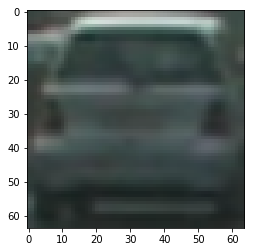

[1 0]


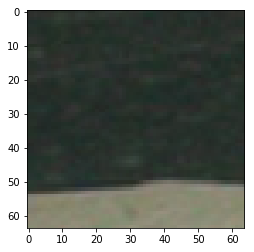

[0 1]


In [4]:
# Adatábzis betöltése
raw_data_car = glob.glob("./Database/vehicles/*/*.png")
raw_data_non_car = glob.glob("./Database/non-vehicles/*/*.png")

# Adatbázis mérete
print("Autó db: " + str(len(raw_data_car)))
print("Nem Autó db: " + str(len(raw_data_non_car)))
print("Összesen db: " + str(len(raw_data_car) + len(raw_data_non_car)))

all_data_input = []
all_data_output = []
all_data_output2 = []

# Képek betöltése
for pic in raw_data_car:   
    all_data_input.append(cv2.cvtColor(cv2.imread(pic), cv2.COLOR_BGR2RGB))
    all_data_output.append((1,0))
for pic in raw_data_non_car: 
    all_data_input.append(cv2.cvtColor(cv2.imread(pic), cv2.COLOR_BGR2RGB))
    all_data_output.append((0,1))
        
#Összes kép
all_data_input = np.array(all_data_input)
all_data_output = np.array(all_data_output)

print(all_data_input.shape)

plt.imshow(all_data_input[0])
plt.show()
print(all_data_output[0])
plt.imshow(all_data_input[10001])
plt.show()
print(all_data_output[10001])

Tanító adatok be : (15984, 64, 64, 3)
Tanító adatok ki: (15984, 2)
Tesztelő adatok be: (1775, 64, 64, 3)
Tesztelő adatok ki: (1775, 2)
tanító be:  (15984, 64, 64, 3)
tanító ki (15984, 2)
teszt be (1775, 64, 64, 3)
teszt ki (1775, 2)


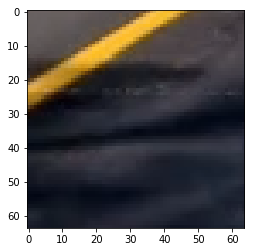

[0 1]


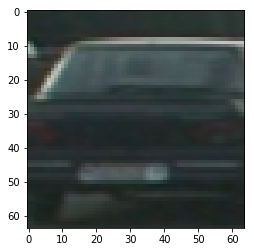

[1 0]


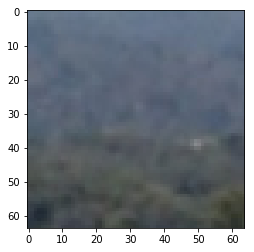

[0 1]


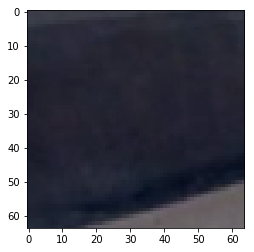

[0 1]


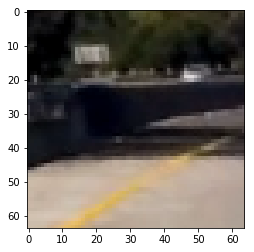

[0 1]


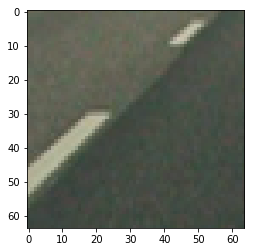

[0 1]


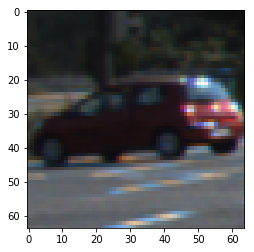

[1 0]


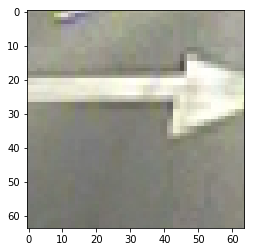

[0 1]


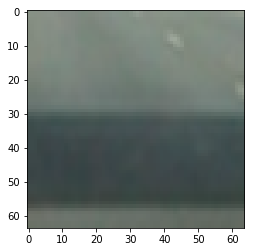

[0 1]


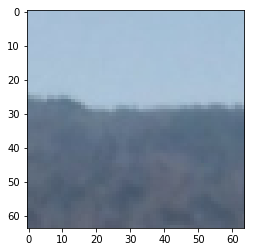

[0 1]


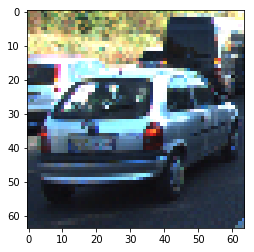

[1 0]


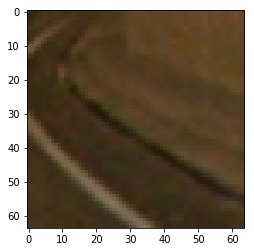

[0 1]


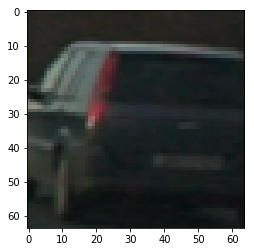

[1 0]


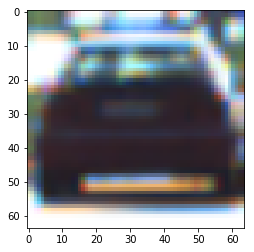

[1 0]


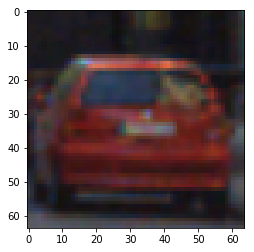

[1 0]


In [5]:
#Megkeverjük az adatokat
shuffle_pack = list(zip(all_data_input, all_data_output))
random.shuffle(shuffle_pack)

shuffled_data_input, shuffled_data_output = zip(*shuffle_pack)

shuffled_data_input = np.array(shuffled_data_input)
shuffled_data_output = np.array(shuffled_data_output)

data_samples = shuffled_data_input.shape[0]
train_samples = int(shuffled_data_input.shape[0] * 0.9)
test_samples = data_samples - train_samples

train_data_input = shuffled_data_input[0:train_samples][:][:]
train_data_output = shuffled_data_output[0:train_samples][:][:]

test_data_input = shuffled_data_input[train_samples:data_samples-1][:][:]
test_data_output = shuffled_data_output[train_samples:data_samples-1][:][:]

print("Tanító adatok be : " +  str(train_data_input.shape))
print("Tanító adatok ki: " +  str(train_data_output.shape))
print("Tesztelő adatok be: " +str(test_data_input.shape))
print("Tesztelő adatok ki: " +str(test_data_output.shape))

#A képek megváltoztak

print("tanító be: " , train_data_input.shape)
print("tanító ki" , train_data_output.shape)
print("teszt be" , test_data_input.shape)
print("teszt ki" , test_data_output.shape)

for i in range(0,15000,1000):
    plt.imshow(train_data_input[i])
    plt.show()
    print(train_data_output[i])


input_shape =  (64,64,3)

In [6]:
def build_conv_model(input_shape = (64,64,3), filename="weights.h5"):
    
    # Modell létrehozása
    model = Sequential()
    model.add(Conv2D(4, (2, 2), input_shape=input_shape, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(8, (2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(16, (2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(32, (2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
     
    return model

In [7]:
model = build_conv_model(input_shape)
model.compile(loss='mean_squared_error',optimizer='sgd',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 4)         52        
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         136       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 16)        528       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
__________

In [ ]:
# Tanítás
model.fit(train_data_input, 
          train_data_output, 
          batch_size=256, 
          epochs=50, 
          verbose=1, 
          validation_data=(test_data_input, test_data_output))

# Tesztelés
score = model.evaluate(test_data_input, test_data_output, verbose=0)
print(model.metrics_names[0] , ' - ', score[0])
print(model.metrics_names[1] , ' - ', score[1])

# Modell és súlyok mentése
model.save("model.h5")
model.save_weights("weights.h5")

Train on 15984 samples, validate on 1775 samples
Epoch 1/50


## Mély neurális háló mentése Protobuf fájlba

In [20]:
from keras.models import load_model
import tensorflow as tf
import os
import os.path as osp
from keras import backend as K

from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

In [21]:
weight_file = 'model.h5'
num_output = 1
write_graph_def_ascii_flag = True
prefix_output_node_names_of_final_network = 'output'
output_graph_name = 'car_modell.pb'
output_fld=""

In [22]:
output_fld = 'tensorflow_model/'
if not os.path.isdir(output_fld):
    os.mkdir(output_fld)

In [23]:
K.set_learning_phase(0)
net_model = load_model(weight_file)

pred = [None]*num_output
pred_node_names = [None]*num_output
for i in range(num_output):
    pred_node_names[i] = prefix_output_node_names_of_final_network+str(i)
    pred[i] = tf.identity(net_model.output[i], name=pred_node_names[i])
print('output nodes names are: ', pred_node_names)

output nodes names are:  ['output0']


In [24]:
sess = K.get_session()

if write_graph_def_ascii_flag:
    f = 'only_the_graph_def.pb.ascii'
    tf.train.write_graph(sess.graph.as_graph_def(), output_fld, f, as_text=True)
    print('saved the graph definition in ascii format at: ', osp.join(output_fld, f))

saved the graph definition in ascii format at:  tensorflow_model/only_the_graph_def.pb.ascii


In [25]:
constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, output_fld, output_graph_name, as_text=False)
print('saved the constant graph (ready for inference) at: ', osp.join(output_fld, output_graph_name))

INFO:tensorflow:Froze 12 variables.
Converted 12 variables to const ops.
saved the constant graph (ready for inference) at:  tensorflow_model/car_modell.pb
